In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns

In [2]:
loans_raw = pd.read_csv("https://raw.githubusercontent.com/mrbarron3/stat451/main/loan_data.csv")
loans_p = loans_raw[["purpose", "int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "delinq.2yrs", "not.fully.paid"]]

loans = loans_p.join(pd.get_dummies(loans_p.purpose))
loans = loans.drop("purpose", axis=1)


print(len(loans_raw))

loans.head()

9578


,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,delinq.2yrs,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,0,0,0,0,1,0,0,0,0
1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,0,0,0,1,0,0,0,0,0
2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,0,0,0,0,1,0,0,0,0
3,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,0,0,0,0,1,0,0,0,0
4,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,1,0,0,1,0,0,0,0,0


In [3]:
loans.describe()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,delinq.2yrs,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,0.163708,0.160054,0.243370,0.131760,0.413134,0.035811,0.065671,0.045625,0.064627
std,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,0.546215,0.366676,0.429139,0.338248,0.492422,0.185829,0.247720,0.208682,0.245880
min,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


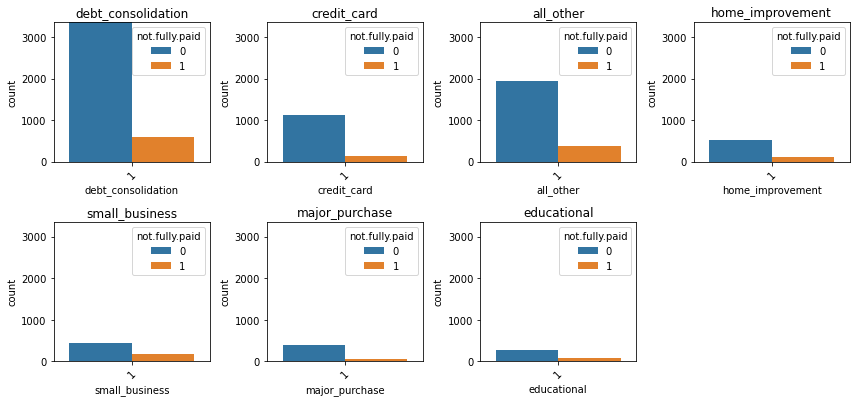

In [4]:
# Adjusting the code to set the same y-axis scale for all subplots

# Extracting the loan purposes
loan_purposes = []
for purpose in loans_p["purpose"]:
    if purpose not in loan_purposes:
        loan_purposes.append(purpose)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Creating a grid of countplots
max_y = 0  
for purpose in loan_purposes:
    df = loans[loans[purpose] == 1]
    current_plot = sns.countplot(x=df[purpose], hue=loans['not.fully.paid'], data=loans)
    max_y = max(max_y, max([p.get_height() for p in current_plot.patches]))  

for index, purpose in enumerate(loan_purposes):
    plt.subplot(3, 4, index+1)  
    sns.countplot(x=loans[loans[purpose] == 1][purpose], hue=loans['not.fully.paid'])
    plt.ylim(0, max_y)  
    plt.title(purpose)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
X = loans.drop(columns=['not.fully.paid'])
y = loans['not.fully.paid']

header = list(X.columns)


X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)


In [6]:

zeroDelinq = X[X['delinq.2yrs'] == 0]
percent_zeros1 = len(zeroDelinq) / 9577
print(f'Percentage of 0s for delinq.2yrs feature variable {percent_zeros1}')

zero1 = X[X['all_other'] == 0]
percent_zeros9 = len(zero1) / 9577
print(f'Percentage of 0s for loan purpose:all_other feature variable {percent_zeros9}')

zero2 = X[X['credit_card'] == 0]
percent_zeros3 = len(zero2) / 9577
print(f'Percentage of 0s for loan purpose:credit_card feature variable {percent_zeros3}')

zero3 = X[X['debt_consolidation'] == 0]
percent_zeros4 = len(zero3) / 9577
print(f'Percentage of 0s for loan purpose:debt_consolidation feature variable {percent_zeros4}')

zero4 = X[X['educational'] == 0]
percent_zeros5 = len(zero4) / 9577
print(f'Percentage of 0s for loan purpose:educational feature variable {percent_zeros5}')

zero5 = X[X['home_improvement'] == 0]
percent_zeros6 = len(zero5) / 9577
print(f'Percentage of 0s for loan purpose:home_improvement feature variable {percent_zeros6}')

zero6 = X[X['major_purchase'] == 0]
percent_zeros7 = len(zero6) / 9577
print(f'Percentage of 0s for loan purpose:major_purchase feature variable {percent_zeros7}')

zero7 = X[X['small_business'] == 0]
percent_zeros8 = len(zero7) / 9577
print(f'Percentage of 0s for loan purpose:small_business feature variable {percent_zeros8}')


#interpretation: you can guess that someone will pay back their loan by guessing 0 and you will be accurate 84% of the time

zeroY = y[y == 0]
percent_zeros2 = len(zeroY) / 9577
print(f'Percentage of 0s for y variable. Whether someone will not pay back their loan {percent_zeros2}')

   
#9577    

Percentage of 0s for delinq.2yrs feature variable 0.883157564999478
Percentage of 0s for loan purpose:all_other feature variable 0.7567087814555706
Percentage of 0s for loan purpose:credit_card feature variable 0.8683303748564268
Percentage of 0s for loan purpose:debt_consolidation feature variable 0.5869270126344367
Percentage of 0s for loan purpose:educational feature variable 0.9642894434582855
Percentage of 0s for loan purpose:home_improvement feature variable 0.9344262295081968
Percentage of 0s for loan purpose:major_purchase feature variable 0.9544742612509136
Percentage of 0s for loan purpose:small_business feature variable 0.9354703978281299
Percentage of 0s for y variable. Whether someone will not pay back their loan 0.8400334133862378


In [7]:
classifiers = [
    linear_model.LogisticRegression(max_iter=5000), 
    DecisionTreeClassifier(), 
    KNeighborsClassifier()
]
parameters = [ 
    {'C': [0.01, 1, 100]},
    {'criterion': ['entropy'], 'max_depth': [1, 3, 5, 7]},
    {'n_neighbors': [1, 2, 3, 4]}
]

best_idx = -1
best_accuracy = -np.Inf
best_clf = None

for i in range(len(classifiers)):
    if isinstance(classifiers[i], svm.SVC):
        clf = RandomizedSearchCV(classifiers[i], parameters[i])
    else:
        clf = GridSearchCV(classifiers[i], parameters[i])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_valid, y_valid)
    if np.any(accuracy > best_accuracy):
        best_idx = i
        best_accuracy = accuracy 
        best_clf = clf
        best_params = clf.best_params_
    elif np.all(accuracy == best_accuracy):
        if type(best_clf) != list:
            best_idx = [best_idx, i]
            best_accuracy = [best_accuracy, accuracy] 
            best_clf = [best_clf, clf]
            best_params = [best_params, clf.best_params_]
        
print(f'The best classifiers are {[classifiers[best_idx[0]], classifiers[best_idx[1]]]} with the parameters {best_params}')

print(f'best accuracy is are {best_accuracy}')

The best classifiers are [LogisticRegression(max_iter=5000), DecisionTreeClassifier()] with the parameters [{'C': 0.01}, {'criterion': 'entropy', 'max_depth': 1}]
best accuracy is are [0.8392484342379958, 0.8392484342379958]


In [8]:
#how much does the score differ for different classifiers and parameterS?

model = linear_model.LogisticRegression(max_iter=5000, C = 0.01)
model2 = linear_model.LogisticRegression(max_iter=5000, C = 1)
model3 = linear_model.LogisticRegression(max_iter=5000, C = 100)

model.fit(X_train, y_train)
print(f'Log regression with C = .01: {model.score(X_valid, y_valid)}')


model2.fit(X_train, y_train)      
print(f'Log regression with C = 1: {model2.score(X_valid, y_valid)}')


model3.fit(X_train, y_train)
      
print(f'Log regression with C = 100: {model3.score(X_valid, y_valid)}')


Log regression with C = .01: 0.8392484342379958
Log regression with C = 1: 0.8392484342379958
Log regression with C = 100: 0.8392484342379958


In [9]:
model4 = KNeighborsClassifier(n_neighbors = 1)
model5 = KNeighborsClassifier(n_neighbors =2 )
model6 = KNeighborsClassifier(n_neighbors = 3)
model7 = KNeighborsClassifier(n_neighbors = 4)

model4.fit(X_train, y_train)
print(f'KNN Classifier with n_neighbors = 1: {model4.score(X_valid, y_valid)}')

model5.fit(X_train, y_train)
print(f'KNN Classifier with n_neighbors = 2: {model5.score(X_valid, y_valid)}')

model6.fit(X_train, y_train)
print(f'KNN Classifier with n_neighbors = 3: {model6.score(X_valid, y_valid)}')

model7.fit(X_train, y_train)
print(f'KNN Classifier with n_neighbors = 4: {model7.score(X_valid, y_valid)}')

KNN Classifier with n_neighbors = 1: 0.7536534446764092
KNN Classifier with n_neighbors = 2: 0.8215031315240083
KNN Classifier with n_neighbors = 3: 0.7922755741127349
KNN Classifier with n_neighbors = 4: 0.826722338204593


In [10]:
model8 = DecisionTreeClassifier(criterion= 'entropy', max_depth = 1)
model9 = DecisionTreeClassifier(criterion= 'entropy', max_depth= 3)
model10 = DecisionTreeClassifier(criterion= 'entropy', max_depth = 5)
model11 = DecisionTreeClassifier(criterion= 'entropy', max_depth = 7)

model8.fit(X_train, y_train)
print(f'Tree Classifier with n_neighbors = 1: {model8.score(X_valid, y_valid)}')

model9.fit(X_train, y_train)
print(f'Tree Classifier with n_neighbors = 3: {model9.score(X_valid, y_valid)}')

model10.fit(X_train, y_train)
print(f'Tree Classifier with n_neighbors = 5: {model10.score(X_valid, y_valid)}')

model11.fit(X_train, y_train)
print(f'Tree Classifier with n_neighbors = 7: {model11.score(X_valid, y_valid)}')


Tree Classifier with n_neighbors = 1: 0.8392484342379958
Tree Classifier with n_neighbors = 3: 0.8361169102296451
Tree Classifier with n_neighbors = 5: 0.8340292275574113
Tree Classifier with n_neighbors = 7: 0.8350730688935282


In [11]:
#use training and testing data with the best classifier and parameters
#is MSE train < MSE test then overfitting 
#useful model outperforms the mean model 

model1 = linear_model.LogisticRegression(max_iter=5000, C = .01)
model1.fit(X_train, y_train)
MSE_train1 = (1/y_train.size) * np.sum((y_train - model1.predict(X_train))**2)
MSE_test1 = (1/y_test.size)  * np.sum((y_test - model1.predict(X_test))**2)
print(f' MSE train for logistic regression {MSE_train1}')
print(f' MSE test for logistic regression {MSE_test1}')


modelTree = DecisionTreeClassifier(criterion='entropy', max_depth = 1)
modelTree.fit(X_train, y_train)
MSE_train1 = (1/y_train.size) * np.sum((y_train - modelTree.predict(X_train))**2)
MSE_test1 = (1/y_test.size)  * np.sum((y_test - modelTree.predict(X_test))**2)
print(f' MSE train for decision tree classifier is {MSE_train1}')
print(f' MSE test for decision tree classifier is {MSE_test1}')

 MSE train for logistic regression 0.15987992691203343
 MSE test for logistic regression 0.16075156576200417
 MSE train for decision tree classifier is 0.16001044113808408
 MSE test for decision tree classifier is 0.15970772442588724


In [12]:
model = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', random_state = 0)

model.fit(X_train, y_train)
MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2) 
w = model.coef_[0] 
intercept = model.intercept_

print(f"MSE train: {MSE_train}, MSE test: {MSE_test}")

print(f"The coefficients are {w}")
print(f"These coefficients match up with these header names: {header}")

non_zero_vars = []
for i in range(len(w)):
    #5e-01
    #change atol 
    #.05
    if np.isclose(w[i], 0, atol=1e-2):
        continue
    non_zero_vars.append(header[i])
    
non_zero_vars

MSE train: 0.1592273557817802, MSE test: 0.16179540709812107
The coefficients are [ 7.02622393e+00  7.66361562e-04 -2.91390653e-01  1.49271343e-03
 -7.10914602e-03 -2.57609505e-06  4.40112707e-06 -2.32195024e-02
  2.71845008e-01 -2.88097718e-01  0.00000000e+00  3.47919390e-01
  4.11956700e-01  0.00000000e+00  7.67315525e-01]
These coefficients match up with these header names: ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'delinq.2yrs', 'all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']


['int.rate',
 'log.annual.inc',
 'delinq.2yrs',
 'all_other',
 'credit_card',
 'educational',
 'home_improvement',
 'small_business']

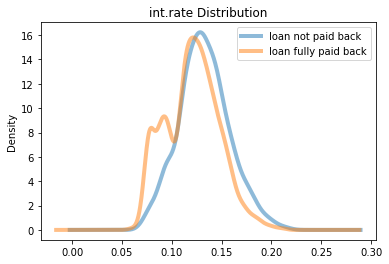

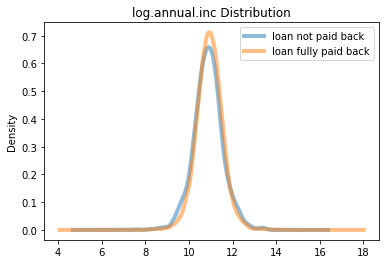

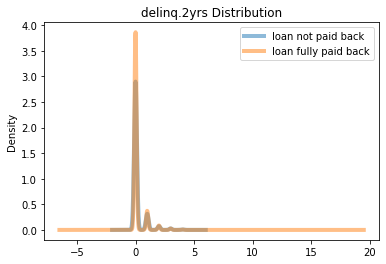

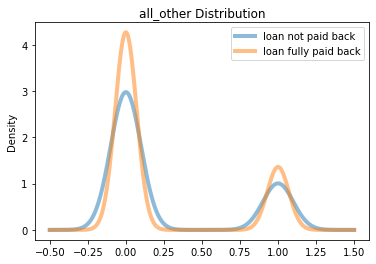

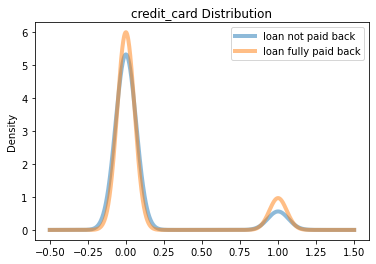

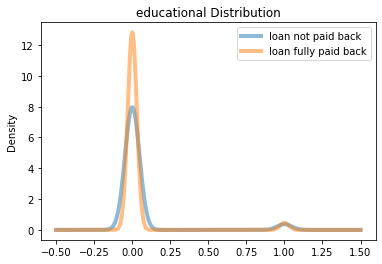

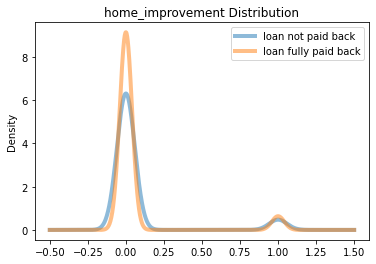

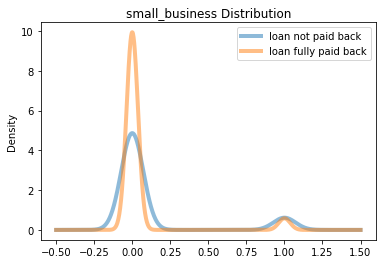

In [13]:
for var in non_zero_vars:
    loans[loans["not.fully.paid"] == 1][var].plot(kind = 'density', alpha = 0.5, label = 'loan not paid back', linewidth=4)
    loans[loans["not.fully.paid"] == 0][var].plot(kind = 'density', alpha = 0.5, label = 'loan fully paid back', linewidth=4)
    
    plt.title(f"{var} Distribution")
    plt.legend()
    plt.show(block=False)

In [14]:
#logistic curve for the features that were important 


In [15]:
model2 = linear_model.LogisticRegression(penalty='l2')

model2.fit(X_train, y_train)
MSE_train2 = (1/y_train.size) * np.sum((y_train - model2.predict(X_train))**2)
MSE_test2 = (1/y_test.size)  * np.sum((y_test - model2.predict(X_test))**2) 
w2 = model2.coef_[1:] 
intercept = model2.intercept_

print(f"Ridge MSE train: {MSE_train2}, Ridge MSE test: {MSE_test2}")
print(f"Lasso MSE train: {MSE_train}, Lasso MSE test: {MSE_test}")




Ridge MSE train: 0.15987992691203343, Ridge MSE test: 0.16075156576200417
Lasso MSE train: 0.1592273557817802, Lasso MSE test: 0.16179540709812107


Optimal alpha: 0.01


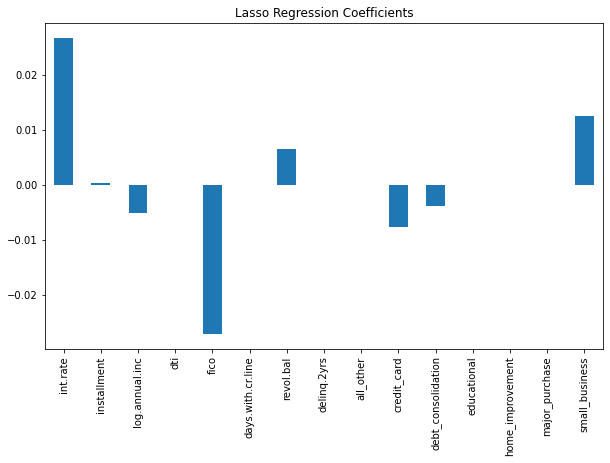

In [16]:
#plot the training data, test data, lasso,ridge, and log regression through a graph like in https://pages.stat.wisc.edu/~jgillett/451/burkov/05/05modelFitRegularize.html

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
import seaborn as sns
import numpy as np

X = loans.drop('not.fully.paid', axis=1)
y = loans['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.01, 0.05, 0.1, 1] 
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print("Optimal alpha:", optimal_alpha)

lasso_model = Lasso(alpha=optimal_alpha )
lasso_model.fit(X_train_scaled, y_train)
coefficients = pd.Series(lasso_model.coef_, index=X.columns)
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Regression Coefficients')
plt.show()

/Users/gracedeis/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/gracedeis/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/gracedeis/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


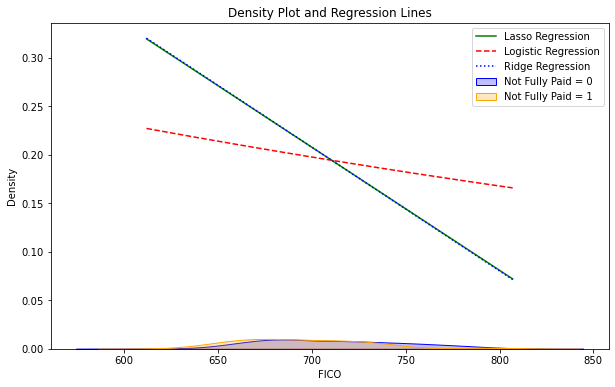

In [17]:
X = df[['fico']]
y = df['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define models
lasso = Lasso(alpha=.01, max_iter=2000)
ridge=Ridge()
logistic = LogisticRegression()

# Fit the models
lasso.fit(X_train, y_train)
logistic.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Generate data for density plot
x_plot = np.linspace(df['fico'].min(), df['fico'].max(), 1000)
y_plot_lasso = lasso.predict(x_plot.reshape(-1, 1))
y_plot_logistic = logistic.predict_proba(x_plot.reshape(-1, 1))[:, 1]
y_plot_ridge = ridge.predict(x_plot.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.kdeplot(df['fico'][df['not.fully.paid'] == 0], label='Not Fully Paid = 0', color='blue', fill=True)
sns.kdeplot(df['fico'][df['not.fully.paid'] == 1], label='Not Fully Paid = 1', color='orange', fill=True)
plt.plot(x_plot, y_plot_lasso, label='Lasso Regression', linestyle='solid', color='green')
plt.plot(x_plot, y_plot_logistic, label='Logistic Regression', linestyle='dashed', color='red')
plt.plot(x_plot, y_plot_ridge, label='Ridge Regression', linestyle='dotted', color='blue')

plt.title('Density Plot and Regression Lines')
plt.xlabel('FICO')
plt.ylabel('Density')
plt.legend()
plt.show()

pi.importances_mean=[0.]


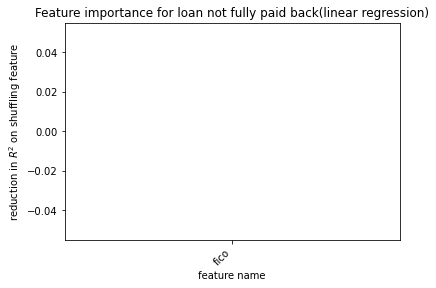

In [18]:
modelPerm = linear_model.LogisticRegression(C=.01)
# Also try varying C, above.
modelPerm.fit(X, y)

pi = permutation_importance(estimator=modelPerm, X=X, y=y, random_state=0)
print(f'pi.importances_mean={pi.importances_mean}')
#print(f'pi.importances_std={pi.importances_std}')
#print(f'pi.importances={pi.importances}')
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.xticks(rotation=45, ha='right')
plt.title('Feature importance for loan not fully paid back(linear regression)')
plt.xlabel('feature name')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

pi.importances_mean=[0.]
pi.importances_std=[0.]
pi.importances=[[0. 0. 0. 0. 0.]]


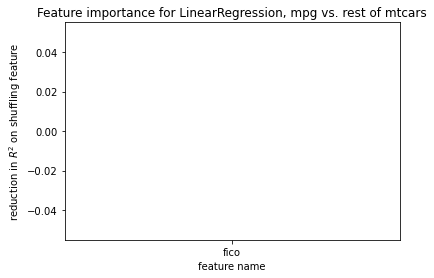

In [19]:
#why doesn't this work

modelPerm2 = DecisionTreeClassifier(criterion='entropy', max_depth= 1)

modelPerm2.fit(X, y)

pi = permutation_importance(estimator=modelPerm2, X=X, y=y, random_state=0)
print(f'pi.importances_mean={pi.importances_mean}')
print(f'pi.importances_std={pi.importances_std}')
print(f'pi.importances={pi.importances}')
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.title('Feature importance for LinearRegression, mpg vs. rest of mtcars')
plt.xlabel('feature name')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

In [20]:
#more to do: feature engineering like data cleaning, rescaling, and imputation.
